## Stacking ML models 

In this notebook, we share an example of stacking classification models. The goal is to utilize three ML algorithms as base-learners and one ML algorithm for meta-learner.

In the first scenario, we only utlize sklearn models and use a logistic regression model as the meta-learner. We will note the accuracy (selected performance metric) of this approach.
Next, we utilize a torch model for meta-learner and note some improvement over utilizing logistic regression as the meta-learner.

Please note that we are not fully optimizing parameters of the models and this notebook is created for the sake of demonstration and showing that stacking can be useful to improve performance of the models.

First, let's import the necessary packages (Python version >= 3.11). 

In [1]:
import numpy as np # 1.26.2
from sklearn.datasets import make_classification # sklearn.__version__ == 1.3.0
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch # 2.0.0+cpu
import torch.nn as nn
import torch.optim as optim
from matplotlib.pylab import plt # 3.7.2
%matplotlib inline

In [2]:
# Defining few global variables
RANDOM_STATE = 1234
TEST_SIZE = 0.2
NEURAL_NETWORK_LAYER_SIZES = [100, 50]
NUMBER_EPOCH = 500
LEARNING_RATE = 0.001

In [3]:
# Generate some synthetic data for a classification task
X, y = make_classification(n_samples=10000, n_features=50, n_informative=20, n_classes=2, random_state=RANDOM_STATE)

In [4]:
# Split data into train and test sets
# For simplicity, we are not validating the models in this notebook and hence to X_val & y_val are populated.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Initialize three base learners, all sklearn models
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
lr = LogisticRegression(random_state=RANDOM_STATE)
svm = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)

# Create a list of base learners and standardize data for LR and SVM models
base_learners = [('Random Forest', rf),
                 ('Logistic Regression', make_pipeline(StandardScaler(), lr)),
                 ('SVM', make_pipeline(StandardScaler(), svm))]

### Utilizing a sklearn model as meta-learner

The next cell may take a few minutes to finish. Please note while stacking can help with performance improvement, it generally results in slower training and inference phases.

In [6]:
lr_meta_learner_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=42))

lr_meta_learner_model.fit(X_train, y_train)
lr_meta_learner_accuracy = lr_meta_learner_model.score(X_test, y_test) # We can also use accuracy_score function, by default .score function calculates accuracy
print(f"Accuracy of the three stacked models with a logistic regression model as a meta-learner: {lr_meta_learner_accuracy:.3f}")

Accuracy of the three stacked models with a logistic regression model as a meta-learner: 0.921


### Utilizing a neural network as meta-learner

In [7]:
# Initialize a neural network as the meta-learner using Torch given a list of layer sizes
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes = NEURAL_NETWORK_LAYER_SIZES):
        super(NeuralNetwork, self).__init__()
        layer_dims = [input_size] + layer_sizes # Adding input_size as the first layer
        layers = []
        
        # Create fully connected layers
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            layers.append(nn.ReLU())

        # Adding the output layer for this classification task
        layers.append(nn.Linear(layer_dims[-1], 2)) 

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
# Get predictions from base learners for the new torch meta-learner
base_learner_predictions_train = np.array([learner.fit(X_train, y_train).predict(X_train) for _, learner in base_learners]).T

In [9]:
# Combine base learner predictions with original features
X_train_for_meta = np.hstack((X_train, base_learner_predictions_train))

# Confirming shape of X_train and X_train for the meta-learner
print("X_train shape: ", X_train.shape)
print("X_train_for_meta shape: ", X_train_for_meta.shape) # We expect to see 3 more features from base learner models

# Convert stacked features to PyTorch tensor
X_train_for_meta_torch = torch.tensor(X_train_for_meta, dtype=torch.float32)
y_train_for_meta_torch = torch.tensor(y_train, dtype=torch.long)

X_train shape:  (8000, 50)
X_train_for_meta shape:  (8000, 53)


In [10]:
# Get predictions from base learners for the test set for the new torch meta-learner
base_learner_predictions_test = np.array([learner.predict(X_test) for _, learner in base_learners]).T

In [11]:
# Combine test set predictions with original features
X_test_for_meta = np.hstack((X_test, base_learner_predictions_test))

# Confirming shape of X_test and X_test for the meta-learner
print("X_test shape: ", X_test.shape)
print("X_test_for_meta shape: ", X_test_for_meta.shape) # We expect to see 3 more features from base learner models

# Convert stacked test set features to PyTorch tensor
X_test_for_meta_torch = torch.tensor(X_test_for_meta, dtype=torch.float32)
y_test_for_meta_torch = torch.tensor(y_test, dtype=torch.long)

X_test shape:  (2000, 50)
X_test_for_meta shape:  (2000, 53)


The next cell may also take a few minutes depending on the number of epochs, data size and other parameters.

In [12]:
# Instantiate the neural network
input_size = X_train_for_meta.shape[1]
torch_model = NeuralNetwork(input_size, layer_sizes=NEURAL_NETWORK_LAYER_SIZES)

# Define loss function and optimizer for the neural network
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=LEARNING_RATE)

# Training the neural network (meta-learner)
# For simplicity, we are not utilizing batch sizes, batch normalization or don't optimize for optimizer or learning rate
epochs = NUMBER_EPOCH
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = torch_model(X_train_for_meta_torch)
    loss = criterion(outputs, y_train_for_meta_torch)
    losses.append(loss.item())
    if epoch%100 == 0:
        print("Epoch # ", epoch, "| loss : ", round(loss.item(), 5))
    loss.backward()
    optimizer.step()

Epoch #  0 | loss :  0.75692
Epoch #  100 | loss :  0.03
Epoch #  200 | loss :  0.00252
Epoch #  300 | loss :  0.00061
Epoch #  400 | loss :  0.0003


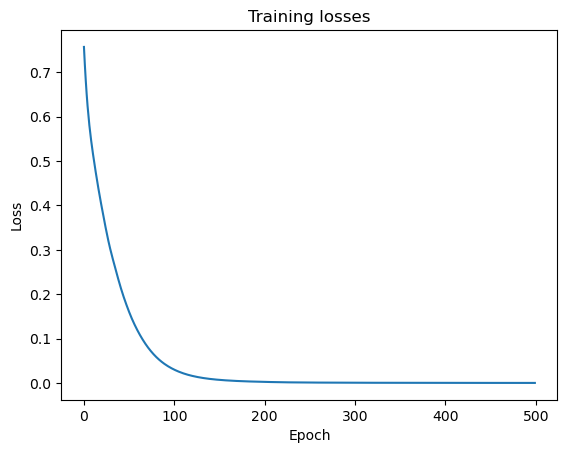

In [13]:
plt.plot(range(epochs), losses)
plt.title("Training losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
# Make predictions using the meta-learner
with torch.no_grad():
    torch_model.eval()
    outputs = torch_model(X_test_for_meta_torch)
    _, predicted = torch.max(outputs, 1)

In [15]:
# Calculate accuracy of the stacked model
torch_meta_learner_accuracy = accuracy_score(y_test, predicted.numpy())
print(f"Accuracy of the stacked model with neural network meta-learner: {torch_meta_learner_accuracy:.3f}")

Accuracy of the stacked model with neural network meta-learner: 0.940
